In [4]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from models import UNetWithAttention
from torchvision.utils import make_grid

In [ ]:
#hyperparameter
T = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
beta_start = 3e-4
beta_end = 0.02
epochs = 200
lr = 2e-4
batch_size = 64

#loading dataset
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
class_idx = 0
filtered_dataset = [(img, label) for img, label in dataset if label == class_idx]
dataloader = torch.utils.data.DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

#noise scheduler
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

#forward diffusion
def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alpha_cumprod_t = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]
    xt = sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise
    return xt, noise

#loss function
def elbo_loss(model, x0, t):
    xt, noise = forward_diffusion(x0, t)
    noise_pred = model(xt, t.float() / T)  
    
    loss = F.mse_loss(noise_pred, noise)  
    return loss

#training unet
def train(model, dataloader, epochs, lr, checkpoint_path=None):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    
    # checkpoint loading
    start_epoch = 0
    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path, weights_only = True)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch}")
    
    # store losses for visualization
    epoch_losses = []
    batch_losses = []
    
    for epoch in range(start_epoch, epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch_idx, (x0, _) in enumerate(progress_bar):
            try:
                x0 = x0.to(device)
                batch_size = x0.shape[0]
                t = torch.randint(0, T, (batch_size,), device=device)
                
                optimizer.zero_grad()
                loss = elbo_loss(model, x0, t)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                # Store batch loss
                batch_loss = loss.item()
                total_loss += batch_loss
                batch_losses.append(batch_loss)
                
                progress_bar.set_postfix({'loss': batch_loss})
                
            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue
        
        # Store epoch loss
        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
        
        # save training every 100 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint_path = f'diffusion_checkpoint_epoch_{epoch+1}.pt'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f"Model saved at {checkpoint_path}")
        
        scheduler.step()
    
    '''
    # debugging     
    plt.figure(figsize=(10, 5))
    plt.plot(batch_losses, label='Batch Loss')
    plt.plot(
        range(0, len(batch_losses)), 
        [epoch_losses[i // len(dataloader)] for i in range(len(batch_losses))], 
        label='Epoch Loss', 
        linewidth=2
    )
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.grid()
    plt.show()
    '''

#verify that data is loaded properly
def verify_dataloader(dataloader):
    print("Verifying dataloader")
    batch = next(iter(dataloader))
    x0, _ = batch
    print(f"Batch shape: {x0.shape}")
    print(f"Value range: [{x0.min():.2f}, {x0.max():.2f}]")
    return True


if __name__ == "__main__":
    #print(f"Using device: {device}")
    #print(f"Dataset size: {len(filtered_dataset)} images")
    
    if verify_dataloader(dataloader):
        model = UNetWithAttention().to(device)
        try:
            train(model, dataloader, epochs=epochs, lr=lr, checkpoint_path='diffusion_checkpoint_epoch_100.pt')
        except Exception as e:
            print(f"Training error: {str(e)}")
            raise e
            

Files already downloaded and verified


'\nif __name__ == "__main__":\n    print(f"Using device: {device}")\n    print(f"Dataset size: {len(filtered_dataset)} images")\n    \n    # Verify dataloader\n    if verify_dataloader(dataloader):\n        # Initialize model with self-attention\n        model = UNetWithAttention().to(device)\n        \n        # Train model\n        try:\n            train(model, dataloader, epochs=epochs, lr=lr, checkpoint_path=\'diffusion_checkpoint_epoch_100.pt\')\n        except Exception as e:\n            print(f"Training error: {str(e)}")\n            raise e\n            '

Successfully loaded model from diffusion_checkpoint_epoch_800.pt


Sampling: 1000it [00:44, 22.65it/s]


Visualizing samples at native 32x32 resolution


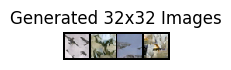

Visualizing izoomed images


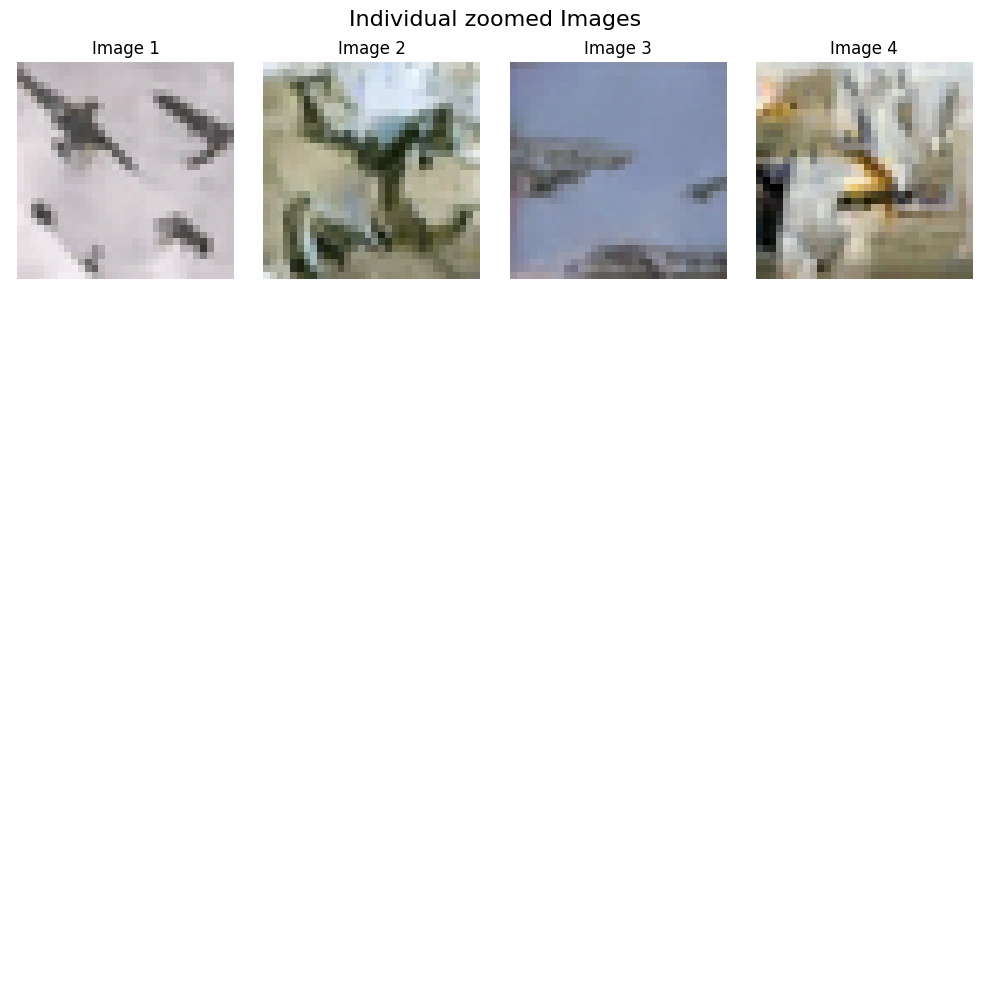

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 1000
beta_start = 3e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)


def sample_images(model, n_samples):
    model.eval()
    with torch.no_grad():
        # simulating pure noise
        x = torch.randn(n_samples, 3, 32, 32).to(device)

        # denoising
        for t in tqdm(reversed(range(0, T)), desc='Sampling'):
            t_batch = torch.full((n_samples,), t, device=device)
            predicted_noise = model(x, t_batch.float() / T)

            alpha_t = alphas[t]
            beta_t = betas[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / (torch.sqrt(1 - alphas_cumprod[t]))) * predicted_noise) + torch.sqrt(beta_t) * noise

        # Denormalize images
        x = (x + 1) / 2 
        x = torch.clamp(x, 0, 1)

    return x

# visualisation by zooming in
def zoom_individual_images(images, rows=4, cols=4, figsize=(10, 10), save_path=None):
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu()

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle("Individual zoomed Images", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].permute(1, 2, 0).numpy()
            ax.imshow(img, interpolation='nearest')
            ax.set_title(f"Image {i+1}")
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)

    plt.show()

    return fig

def show_images_at_native_resolution(images, title="Generated 32x32 Images", save_path=None):
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu()

    grid = make_grid(images, nrow=8, padding=2, normalize=False)

    grid_np = grid.permute(1, 2, 0).numpy()

    dpi = 100
    fig_width = grid_np.shape[1] / dpi
    fig_height = grid_np.shape[0] / dpi

    fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    plt.imshow(grid_np, interpolation='nearest')  
    plt.title(title)
    plt.axis('off')

    #n_rows = len(images) // 8 + (1 if len(images) % 8 != 0 else 0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi)

    plt.show()

    return fig

#combined visualisation
def load_and_visualize(checkpoint_path, n_samples=16):
    model = UNetWithAttention().to(device)  

    #loading checkpoiny
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only = True)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Successfully loaded model from {checkpoint_path}")
    except Exception as e:
        print(f"Error loading checkpoint: {str(e)}")
        return

    # Generate images
    try:
        samples = sample_images(model, n_samples=n_samples)

        print("Visualizing samples at native 32x32 resolution")
        show_images_at_native_resolution(samples, title="Generated 32x32 Images",
                                         save_path="native_resolution_samples.png")

        # Visualize individual images zoomed
        print("Visualizing izoomed images")
        zoom_individual_images(samples, rows=4, cols=4,
                               save_path="zoomed_individual_samples.png")

        return samples
    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print("CUDA out of memory. Try reducing the batch size.")
            torch.cuda.empty_cache()
        else:
            print(f"Error during visualization: {str(e)}")
        return None


if __name__ == "__main__":
    checkpoint_path = r"diffusion_checkpoint_epoch_800.pt"
    samples = load_and_visualize(checkpoint_path, n_samples=4)